In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import os
import pandas as pd
target_path = ""
df = pd.read_csv(os.path.join(target_path, "synthetic_coffee_health_10000.csv"))
df['Health_Issues'] = df['Health_Issues'].fillna('None')
df.head()


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,None,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,None,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


За целевой класс выберем Health_Issues


Health_Issues
None        59.41
Mild        35.79
Moderate     4.63
Severe       0.17
Name: proportion, dtype: float64


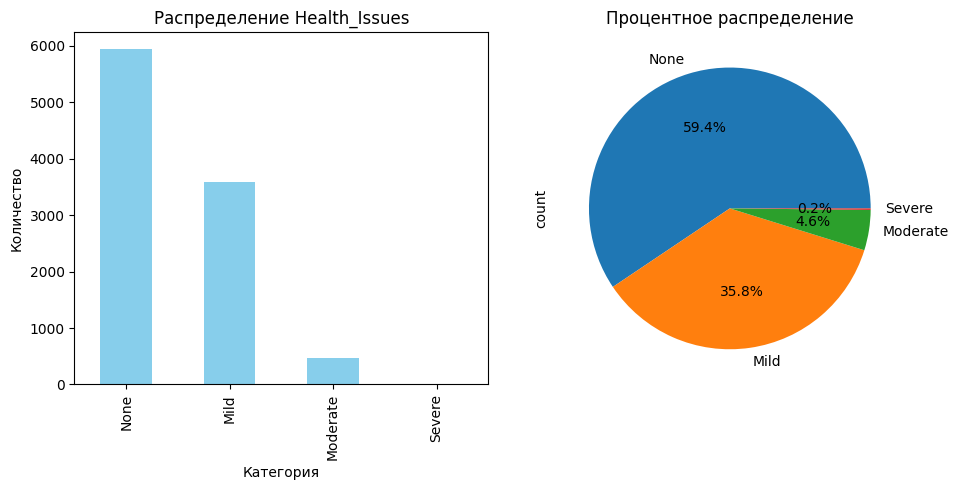

In [8]:
health_distribution = df['Health_Issues'].value_counts(normalize=True) * 100
print(health_distribution)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['Health_Issues'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Распределение Health_Issues')
plt.xlabel('Категория')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
df['Health_Issues'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Процентное распределение')
plt.tight_layout()
plt.show()

In [9]:
df_processed = df.copy()
categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Occupation']
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
df_processed['Smoking'] = df_processed['Smoking'].astype(int)
df_processed['Alcohol_Consumption'] = df_processed['Alcohol_Consumption'].astype(int)
label_encoder = LabelEncoder()
df_processed['Health_Issues_encoded'] = label_encoder.fit_transform(df_processed['Health_Issues'])

print("Соответствие категорий и кодов:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category}: {i}")

X = df_processed.drop(['ID', 'Health_Issues', 'Health_Issues_encoded'], axis=1)
y = df_processed['Health_Issues_encoded']

print(f"\nКоличество признаков: {X.shape[1]}")
print(f"Количество классов в целевой переменной: {len(np.unique(y))}")

Соответствие категорий и кодов:
Mild: 0
Moderate: 1
None: 2
Severe: 3

Количество признаков: 39
Количество классов в целевой переменной: 4


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

feature_names = X.columns.tolist()

Размер обучающей выборки: (7000, 39)
Размер тестовой выборки: (3000, 39)


ДЕРЕВО РЕШЕНИЙ
Fitting 5 folds for each of 224 candidates, totalling 1120 fits

Лучшие параметры дерева: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}

Accuracy (дерево решений): 0.9973

Classification Report (дерево решений):
              precision    recall  f1-score   support

        Mild       0.99      1.00      1.00      1074
    Moderate       1.00      0.96      0.98       139
        None       1.00      1.00      1.00      1782
      Severe       1.00      1.00      1.00         5

    accuracy                           1.00      3000
   macro avg       1.00      0.99      0.99      3000
weighted avg       1.00      1.00      1.00      3000



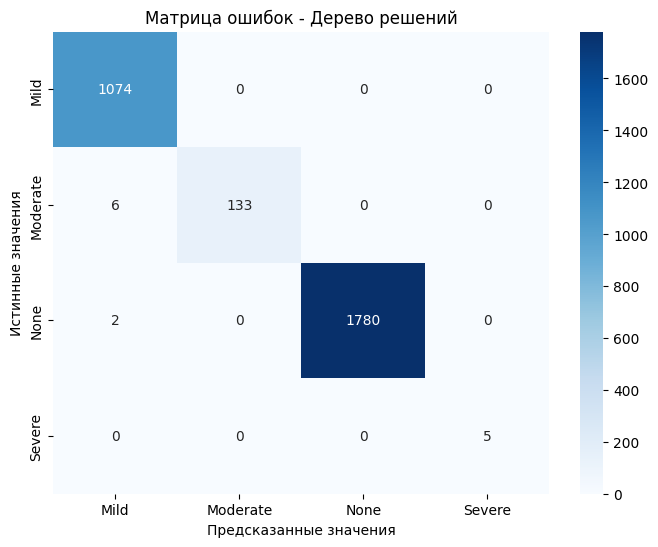

In [11]:
print("ДЕРЕВО РЕШЕНИЙ")
print("=" * 60)

param_grid_tree = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train, y_train)

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_tree,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
dt_grid.fit(X_train, y_train)

dt_best = dt_grid.best_estimator_
print(f"\nЛучшие параметры дерева: {dt_grid.best_params_}")

y_pred_dt = dt_best.predict(X_test)
y_pred_proba_dt = dt_best.predict_proba(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"\nAccuracy (дерево решений): {accuracy_dt:.4f}")

print("\nClassification Report (дерево решений):")
print(classification_report(y_test, y_pred_dt, target_names=label_encoder.classes_))

cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Матрица ошибок - Дерево решений')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

kNN
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Лучшие параметры kNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}

Accuracy (kNN): 0.8597

Classification Report (kNN):
              precision    recall  f1-score   support

        Mild       0.86      0.74      0.80      1074
    Moderate       0.50      0.01      0.01       139
        None       0.86      1.00      0.92      1782
      Severe       0.00      0.00      0.00         5

    accuracy                           0.86      3000
   macro avg       0.55      0.44      0.43      3000
weighted avg       0.84      0.86      0.84      3000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


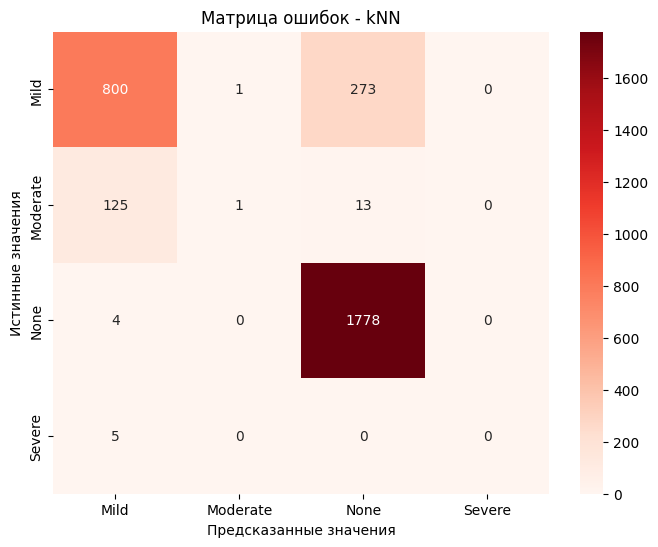

In [12]:
print("kNN")
print("=" * 60)

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
knn_grid.fit(X_train_scaled, y_train)

knn_best = knn_grid.best_estimator_
print(f"\nЛучшие параметры kNN: {knn_grid.best_params_}")

y_pred_knn = knn_best.predict(X_test_scaled)
y_pred_proba_knn = knn_best.predict_proba(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"\nAccuracy (kNN): {accuracy_knn:.4f}")

print("\nClassification Report (kNN):")
print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Reds',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Матрица ошибок - kNN')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

СРАВНЕНИЕ МОДЕЛЕЙ

Сравнение основных метрик:
           Модель  Accuracy                                   Лучшие параметры
0  Дерево решений  0.997333  {'criterion': 'gini', 'max_depth': 5, 'min_sam...
1             kNN  0.859667  {'metric': 'manhattan', 'n_neighbors': 7, 'wei...

Детальные метрики по классам:
                      Модель  precision    recall  f1-score      support
Mild          Дерево решений   0.992606  1.000000  0.996289  1074.000000
Moderate      Дерево решений   1.000000  0.956835  0.977941   139.000000
None          Дерево решений   1.000000  0.998878  0.999439  1782.000000
Severe        Дерево решений   1.000000  1.000000  1.000000     5.000000
accuracy      Дерево решений   0.997333  0.997333  0.997333     0.997333
macro avg     Дерево решений   0.998152  0.988928  0.993417  3000.000000
weighted avg  Дерево решений   0.997353  0.997333  0.997316  3000.000000
Mild                     kNN   0.856531  0.744879  0.796813  1074.000000
Moderate                 kNN 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


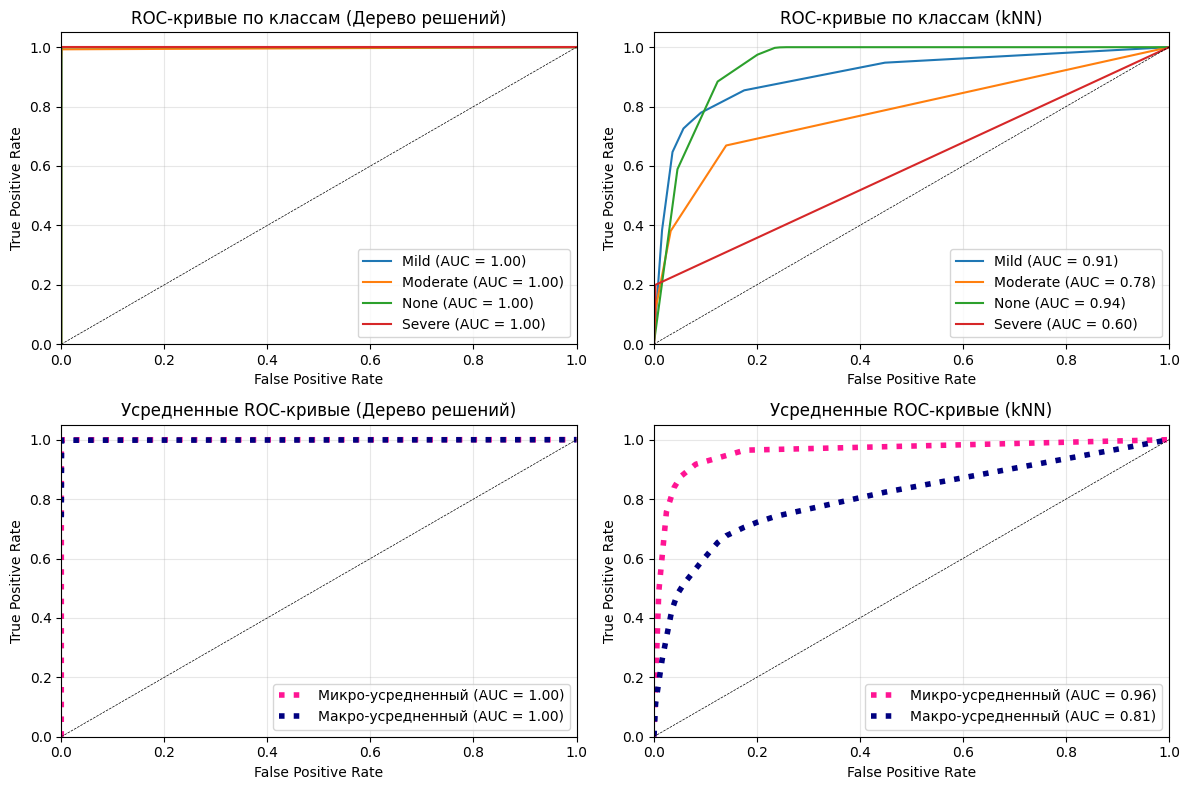

СРАВНЕНИЕ AUC-ROC

Дерево решений:
  Класс Mild: AUC = 0.9997
  Класс Moderate: AUC = 0.9964
  Класс None: AUC = 1.0000
  Класс Severe: AUC = 1.0000
  Средний AUC: 0.9990

kNN:
  Класс Mild: AUC = 0.9055
  Класс Moderate: AUC = 0.7813
  Класс None: AUC = 0.9411
  Класс Severe: AUC = 0.5983
  Средний AUC: 0.8066


In [14]:
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 60)

metrics_comparison = pd.DataFrame({
    'Модель': ['Дерево решений', 'kNN'],
    'Accuracy': [accuracy_dt, accuracy_knn],
    'Лучшие параметры': [str(dt_grid.best_params_), str(knn_grid.best_params_)]
})

print("\nСравнение основных метрик:")
print(metrics_comparison)

def get_detailed_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    metrics_df = pd.DataFrame(report).transpose()
    metrics_df['Модель'] = model_name
    return metrics_df

dt_metrics = get_detailed_metrics(y_test, y_pred_dt, 'Дерево решений')
knn_metrics = get_detailed_metrics(y_test, y_pred_knn, 'kNN')

all_metrics = pd.concat([dt_metrics, knn_metrics])
print("\nДетальные метрики по классам:")
print(all_metrics[['Модель', 'precision', 'recall', 'f1-score', 'support']])

plt.figure(figsize=(12, 8))

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

for i, (model_name, y_pred_proba, color) in enumerate(zip(
    ['Дерево решений', 'kNN'],
    [y_pred_proba_dt, y_pred_proba_knn],
    ['blue', 'red']
)):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for class_idx in range(n_classes):
        fpr[class_idx], tpr[class_idx], _ = roc_curve(
            y_test_bin[:, class_idx],
            y_pred_proba[:, class_idx]
        )
        roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_test_bin.ravel(),
        y_pred_proba.ravel()
    )
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[class_idx] for class_idx in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for class_idx in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[class_idx], tpr[class_idx])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.subplot(2, 2, i+1)

    for class_idx in range(n_classes):
        plt.plot(fpr[class_idx], tpr[class_idx],
                label=f'{label_encoder.classes_[class_idx]} (AUC = {roc_auc[class_idx]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривые по классам ({model_name})')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, i+3)
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Микро-усредненный (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Макро-усредненный (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Усредненные ROC-кривые ({model_name})')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("СРАВНЕНИЕ AUC-ROC")
print("=" * 60)

for model_name, y_pred_proba in [('Дерево решений', y_pred_proba_dt),
                                 ('kNN', y_pred_proba_knn)]:
    auc_scores = []
    for class_idx in range(n_classes):
        auc_class = roc_auc_score(
            (y_test == class_idx).astype(int),
            y_pred_proba[:, class_idx]
        )
        auc_scores.append(auc_class)

    print(f"\n{model_name}:")
    for class_idx, auc_score in enumerate(auc_scores):
        print(f"  Класс {label_encoder.classes_[class_idx]}: AUC = {auc_score:.4f}")
    print(f"  Средний AUC: {np.mean(auc_scores):.4f}")

Дерево решений значительно превзошло kNN по всем метрикам классификации. С точностью 99.73% против 85.97% и средним AUC 0.999 против 0.807, дерево решений демонстрирует почти идеальное разделение классов, в то время как kNN показал крайне низкую эффективность на миноритарных классах (особенно Moderate и Severe). Это объясняется сильной несбалансированностью данных и способностью дерева решений создавать четкие правила классификации, тогда как kNN, основанный на близости объектов, страдает от дисбаланса классов и не может адекватно обрабатывать редкие категории.